# Algorithm

* Goal: Adjacency matrix $A$ minimizing a trade-off between local and global smoothness on the graph. 
* Each node of the network represented by $A$ represents an interpolation signal vectors $m \in M$. 

## Evaluating a candidate $A$

* Given a candidate $A$.
* *Global smoothness*: $tr (\hat{M}^\top L \hat{M} )$.
* *Local smoothness*: measured over the neighbourhood $\mathcal{N}(i)$ of node $i$ as $\left \| m_i - \hat{m}_i \right \|_2^2$.
* The approximation to $m_i$ using only its neighbours is $$\hat{m}_i = \sum_{j \in \mathcal{N}(i)} S^{\tau^*_j}m_j \beta^*_j$$
* The optimal alignment of $m_i$ and a neighbour $m_j$ is $$\tau^*_j = \arg \max_t (m_i \star m_j)(t)$$
* Weights $\beta^*$ are given by OLS using the shifted neighbours.




## Sample a new candidate for $A$

### Random sampling

* Sample $n$ nodes with probability proportional to $\left \| m_i - \hat{m}_i \right \|_2^2$. 
* Assign $k$ new neighbours to each selected node.

### Collaborative filtering

* Sample $n$ nodes with probability proportional to $\left \| m_i - \hat{m}_i \right \|_2^2$. 
* For each selected node, find another node $j$ with the closes resembling neighbourhood measured by e.g. the JAccard similarity.
* Assign the some of the new neighbours of $j$ to $i$.

## Optimization

* *Simulated annealing*. 
* Measure the energy over $A$ as 
$$
    E(A) = \beta \left \| M - \hat{M} \right \|_F^2 + (1 - \beta) tr (\hat{M}^\top L \hat{M} ), \quad \forall A \mid A = A^\top, A_{i,j} \geq 0
$$
* For each iteration
    1. Select a candidate $A$.
    2. Compute $E(A_{n + 1})$ and evaluate $P(E(A_n), E(A_{n + 1}), T(n)) \geq u \sim U(0, 1)$
* Here
$$
P(E(A_n), E(A_{n + 1}), T(n)) = \begin{cases}
1 & \text{ if } E(A_{n+1}) < E(A_n) \\ 
\exp\left ( - \left ( \frac{E(A_{n+1}) - E(A_n)}{T} \right ) \right ) & \text{ otherwise }
\end{cases}
$$
* Annealing schedule
$$T(n) =  \frac{T_0}{2} \left ( 1 - \tanh\left ( 10 \frac{n}{N} - 5 \right ) \right )$$
with $T_0 = E(A_0)$ since is seems like a good idea to have $T_0 \propto E$.


*  Alternative annealing schedules $$
T(n) = \frac{T_0}{2} \left ( 1 + \cos\left ( \frac{n \pi}{N} \right ) \right ), \quad 
T(n) =  \frac{T_0}{\cosh(10 n / N)}
$$


In [1]:
import sys
sys.path.append("../src/")

from time import time 

from scipy import signal
from scipy.sparse import csgraph

from sklearn.metrics import jaccard_score
from sklearn.linear_model import Ridge
from sklearn.cluster import SpectralClustering

import numpy as np 
import matplotlib.pyplot as plt

from graph_learning import (
    annealing, aquisition, utils, profile_synthesis
)

%matplotlib inline

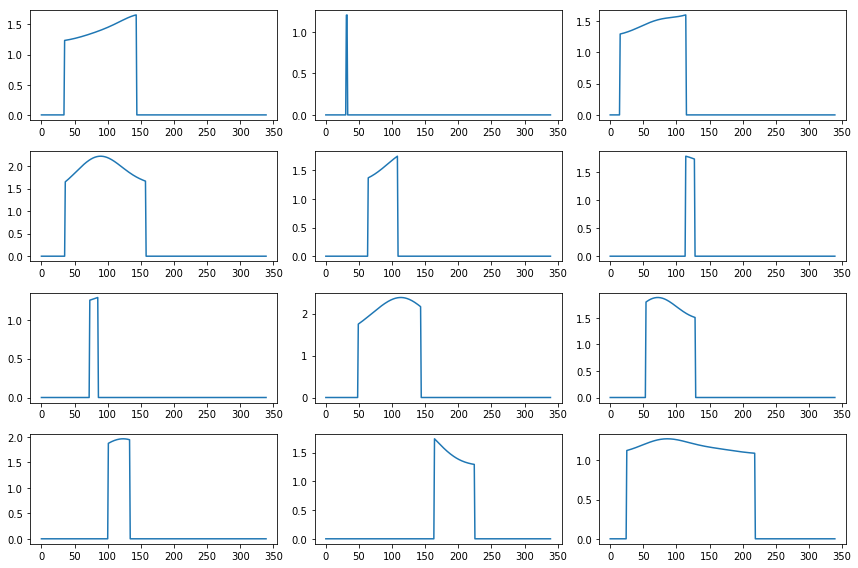

In [2]:
def interpolation_region_mask(Y):
    
    O = np.zeros_like(Y)
    for i, y in enumerate(Y):
        
        t_start = np.argmax(Y[i] != 0)
        t_end = np.argmax(np.cumsum(Y[i])) + 1
        
        O[i, t_start:t_end] = 1
        
    return O


def synthetic_data_gen():
    
    M = np.load("../data/M_train.npy")
    Y = np.load("../data/X_train.npy")
    #Z = np.load("../data/graph_learning/Z.npy")
    #A = np.load("../data/graph_learning/A.npy")
    
    O = interpolation_region_mask(Y)

    return M * O
    
    
def screening_data_gen():
    
    M = np.load("/Users/sela/Desktop/recsys_paper/results/screening/mf/train/train_Xrec.npy")
    Y = np.load("/Users/sela/Desktop/recsys_paper/data/screening/train/X_train.npy")
    O = interpolation_region_mask(Y)

    return M * O


# Choose between synthetic and screening data for demonstration run.
M = synthetic_data_gen()
#M = screening_data_gen()

# Examples of profiles.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 8))
for i, axis in enumerate(axes.ravel()):
    axis.plot(M[i])
plt.tight_layout()

# Profile alignment

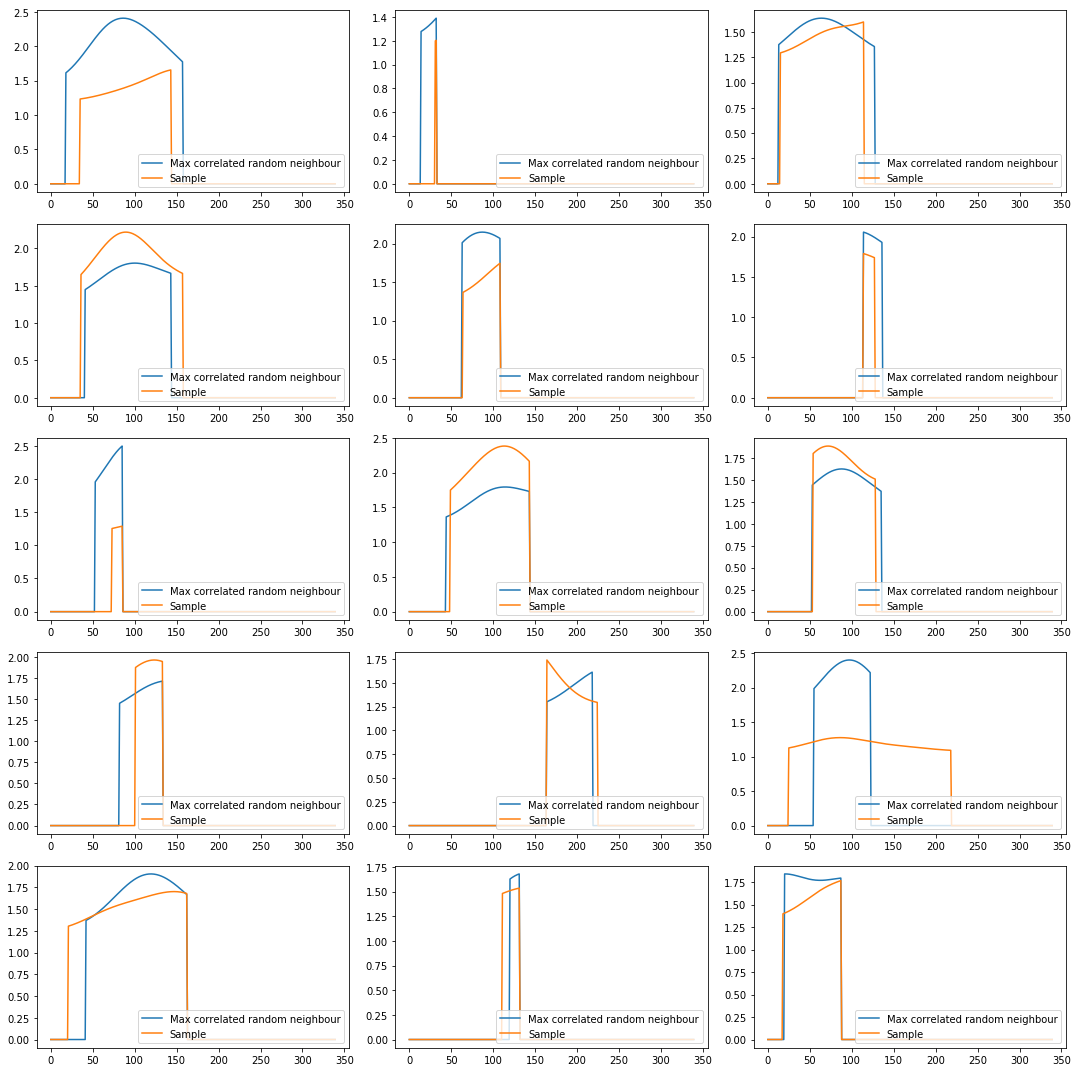

In [3]:
# Find optimal alignment of two random profiles.
np.random.seed(42)

_, axes = plt.subplots(ncols=3, nrows=5, figsize=(15, 15))
for i, axis in enumerate(axes.ravel()):
    
    # Select random neighbours (can also include self in this demonstration).
    N_i = np.asarray(np.random.choice(range(M.shape[0]), size=10, replace=False))    
    
    # Find optimal alignment of elegible neighbours.
    tau_i_star, N_i_star, C_i_star = profile_synthesis.cross_correlation(i=i, N_i=N_i, M=M)
        
    aligned_neighbours = profile_synthesis.align(M[N_i_star], tau_i_star)
    
    # NOTE: Reduce epsilon if C_i_star is empty.
    axis.plot(aligned_neighbours[np.argmax(C_i_star)], label="Max correlated random neighbour")
    axis.plot(M[i], label="Sample")
    axis.legend(loc="lower right")
plt.tight_layout()

# Profile synthesis

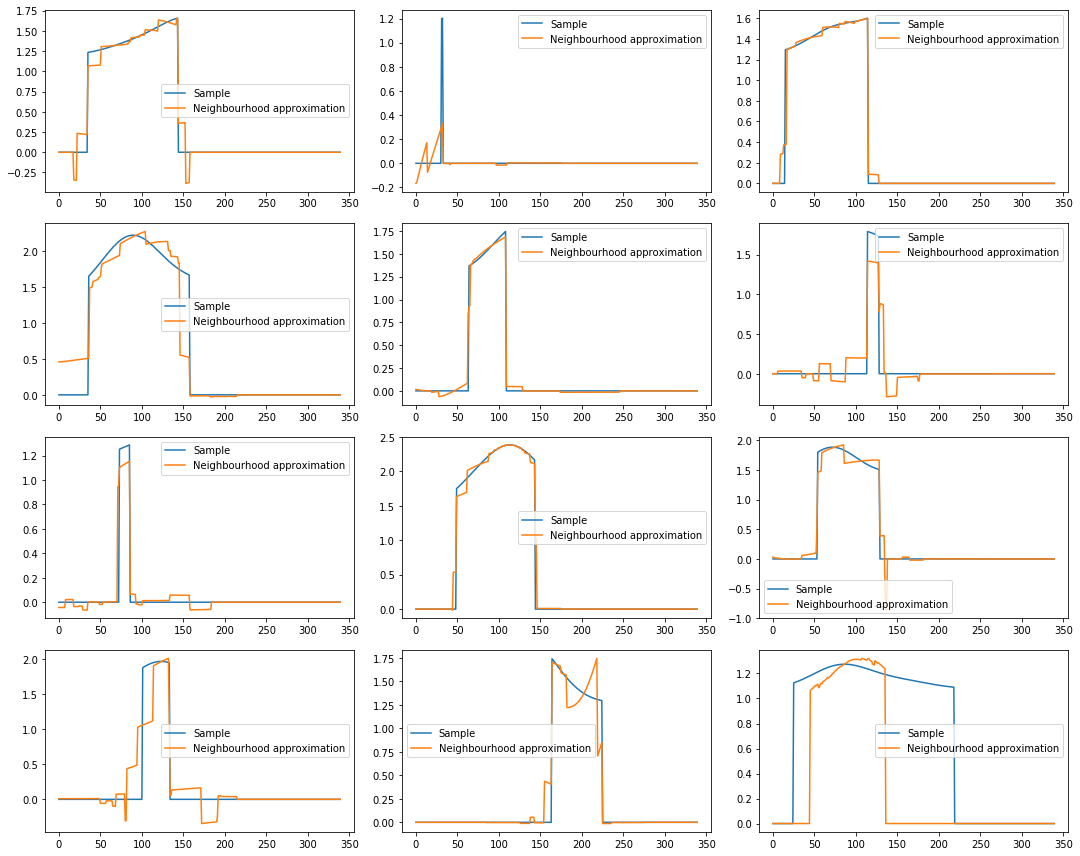

In [4]:
# Find use random profiles to approximate a reference profile.

np.random.seed(42)
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    # Select random neighbours (can also include self in this demonstration).
    N_i = np.asarray(np.random.choice(range(M.shape[0]), size=10, replace=False))    
    
    # Find optimal alignment of elegible neighbours.
    tau_i_star, N_i_star, C_i_star = profile_synthesis.cross_correlation(i=i, N_i=N_i, M=M)
        
    aligned_neighbours = profile_synthesis.align(M[N_i_star], tau_i_star)
    
    axis.plot(M[i], label="Sample")
    axis.plot(profile_synthesis.synthesize(i, M[i], aligned_neighbours), 
              label="Neighbourhood approximation")
    axis.legend()
    
plt.tight_layout()

## Random candidates for $A$

!!!Early stopping after 79 iterations!!!
Duration: 84.99283599853516
Graph density: 0.0582


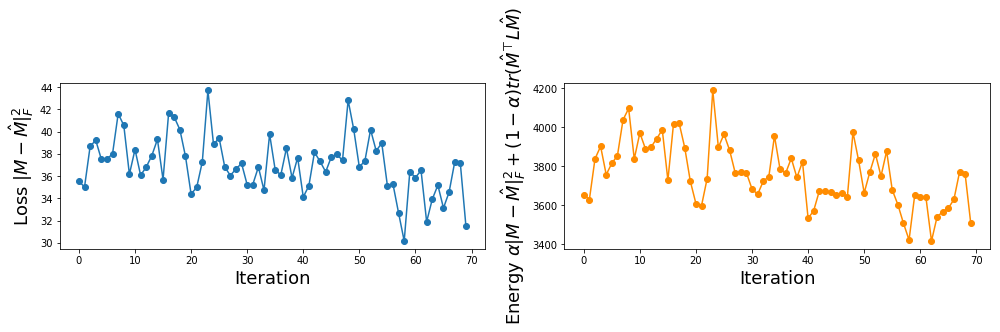

In [5]:
M = synthetic_data_gen()
M_sub = M[:100]

# Initialize random graph.
A_init = utils.intial_adjacency(n=M_sub.shape[0], p=0.1, seed=42)

t0 = time()
A_hat, M_hat, E, L = annealing.estimate_adjacency(A_init, M_sub, method="random", num_epochs=100, n=5, k=5, alpha=0.7)
print("Duration:", time() - t0)
print("Graph density:", np.mean(A_hat))
np.save("../data/graph_learning/A_hat_rnd.npy", A_hat)
np.save("../data/graph_learning/M_hat_rnd.npy", M_hat)

_, axes = plt.subplots(ncols=2, figsize=(14, 4))
axes[0].plot(L, "-o")
axes[0].set_ylabel(r"Loss $\left \| M - \hat{M} \right \|_F ^2$", fontsize=18)
axes[0].set_xlabel("Iteration", fontsize=18)
axes[1].plot(E, "-o", c="darkorange")
axes[1].set_ylabel(r"Energy $\alpha \left \| M - \hat{M} \right \|_F ^2 + (1 - \alpha) tr(\hat{M}^\top L \hat{M})$", fontsize=18)
axes[1].set_xlabel("Iteration", fontsize=18)
plt.tight_layout()

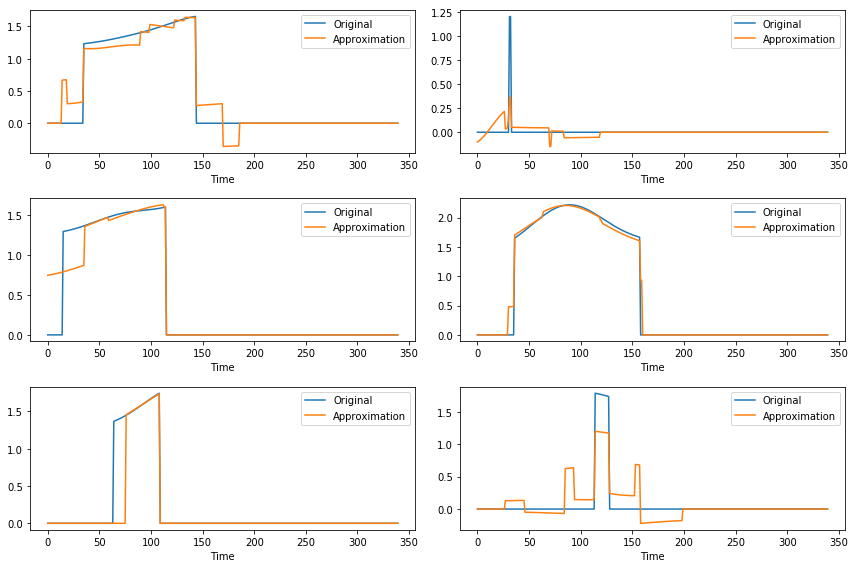

In [6]:
# Neighbouring graph smoothened interpolation signals.
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
for i, axis in enumerate(axes.ravel()):
    
    axis.plot(M_sub[i], label="Original")
    axis.plot(M_hat[i], label="Approximation")
    axis.set_xlabel("Time")
    axis.legend()
    
plt.tight_layout()

## Collaborative filtering for $A$

!!!Early stopping after 91 iterations!!!
Duration: 222.78337693214417
Graph density: 0.2016


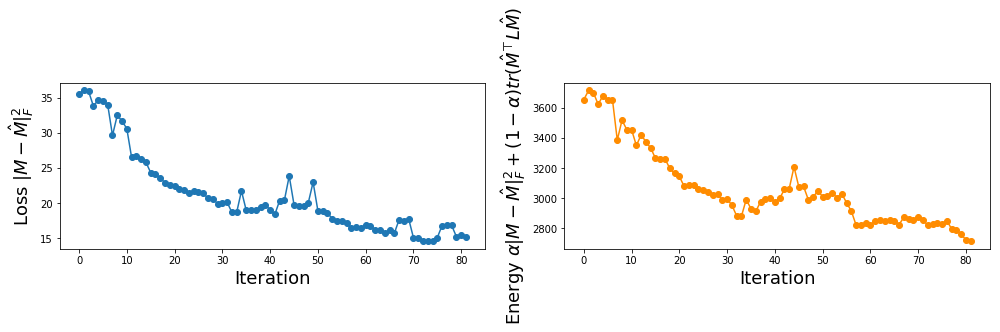

In [7]:
M = synthetic_data_gen()
M_sub = M[:100]

# Initialize random graph.
A_init = utils.intial_adjacency(n=M_sub.shape[0], p=0.1, seed=42)

t0 = time()
A_hat, M_hat, E, L = annealing.estimate_adjacency(A_init, M_sub, method="cf", num_epochs=100, n=5, k=5, alpha=0.7)
print("Duration:", time() - t0)
print("Graph density:", np.mean(A_hat))
#print("J score:", jaccard_score(_A_gt.ravel(), A_hat.ravel()))
np.save("../data/graph_learning/A_hat_cf.npy", A_hat)
np.save("../data/graph_learning/M_hat_cf.npy", M_hat)

_, axes = plt.subplots(ncols=2, figsize=(14, 4))
axes[0].plot(L, "-o")
axes[0].set_ylabel(r"Loss $\left \| M - \hat{M} \right \|_F ^2$", fontsize=18)
axes[0].set_xlabel("Iteration", fontsize=18)
axes[1].plot(E, "-o", c="darkorange")
axes[1].set_ylabel(r"Energy $\alpha \left \| M - \hat{M} \right \|_F ^2 + (1 - \alpha) tr(\hat{M}^\top L \hat{M})$", fontsize=18)
axes[1].set_xlabel("Iteration", fontsize=18)
plt.tight_layout()

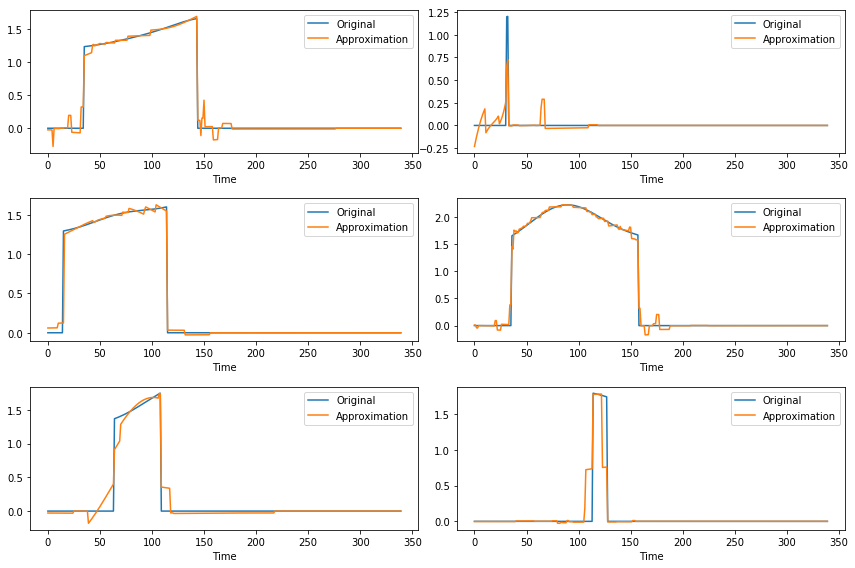

In [8]:
# Neighbouring graph smoothened interpolation signals.
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
for i, axis in enumerate(axes.ravel()):
    
    axis.plot(M_sub[i], label="Original")
    axis.plot(M_hat[i], label="Approximation")
    axis.set_xlabel("Time")
    axis.legend()
    
plt.tight_layout()

# Screening data

In [9]:
M = screening_data_gen()

M_sub = M[:100]

# Initialize random graph.
A_init = utils.intial_adjacency(n=M_sub.shape[0], p=0.1, seed=42)

## Collaborative filtering for $A$

!!!Early stopping after 89 iterations!!!
Duration: 173.60206413269043
Graph density: 0.164


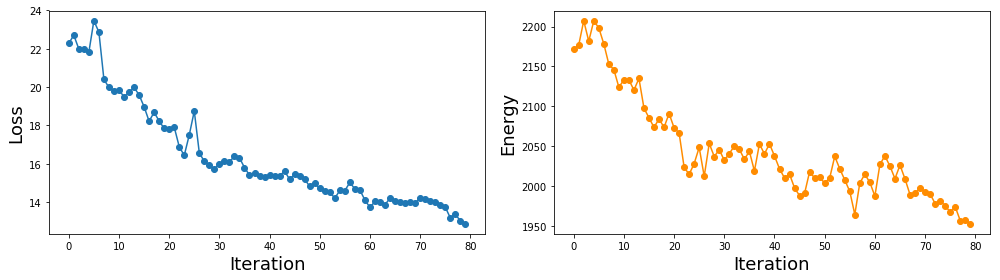

In [10]:
t0 = time()
A_hat, M_hat, E, L = annealing.estimate_adjacency(A_init, M_sub, method="cf", num_epochs=100, n=5, k=5, alpha=0.7)
print("Duration:", time() - t0)
print("Graph density:", np.mean(A_hat))
#print("J score:", jaccard_score(_A_gt.ravel(), A_hat.ravel()))
np.save("../data/graph_learning/A_hat_cf_screen.npy", A_hat)
np.save("../data/graph_learning/M_hat_cf_screen.npy", M_hat)

_, axes = plt.subplots(ncols=2, figsize=(14, 4))
axes[0].plot(L, "-o")
axes[0].set_ylabel("Loss", fontsize=18)
axes[0].set_xlabel("Iteration", fontsize=18)
axes[1].plot(E, "-o", c="darkorange")
axes[1].set_ylabel("Energy", fontsize=18)
axes[1].set_xlabel("Iteration", fontsize=18)
plt.tight_layout()

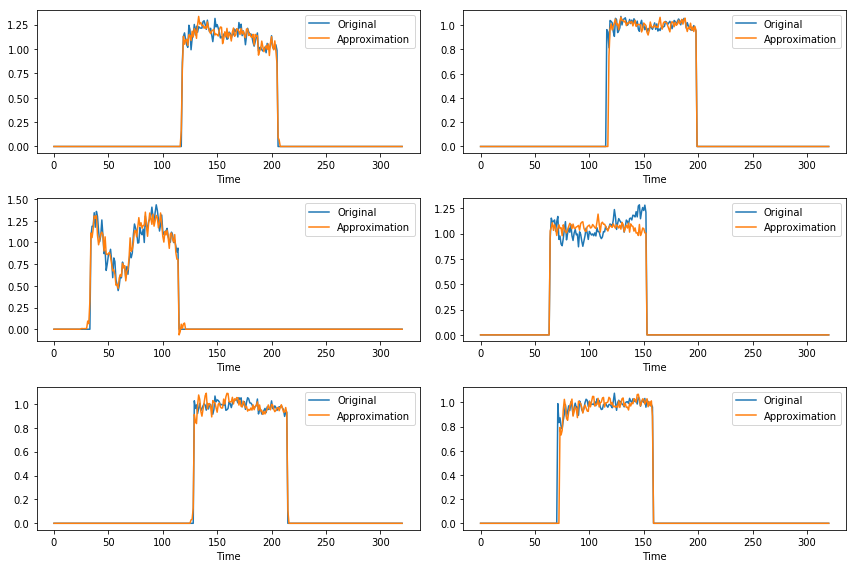

In [11]:
# Neighbouring graph smoothened interpolation signals.
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
for i, axis in enumerate(axes.ravel()):
    
    axis.plot(M_sub[i], label="Original")
    axis.plot(M_hat[i], label="Approximation")
    axis.set_xlabel("Time")
    axis.legend()
    
plt.tight_layout()

## Clustering the graph

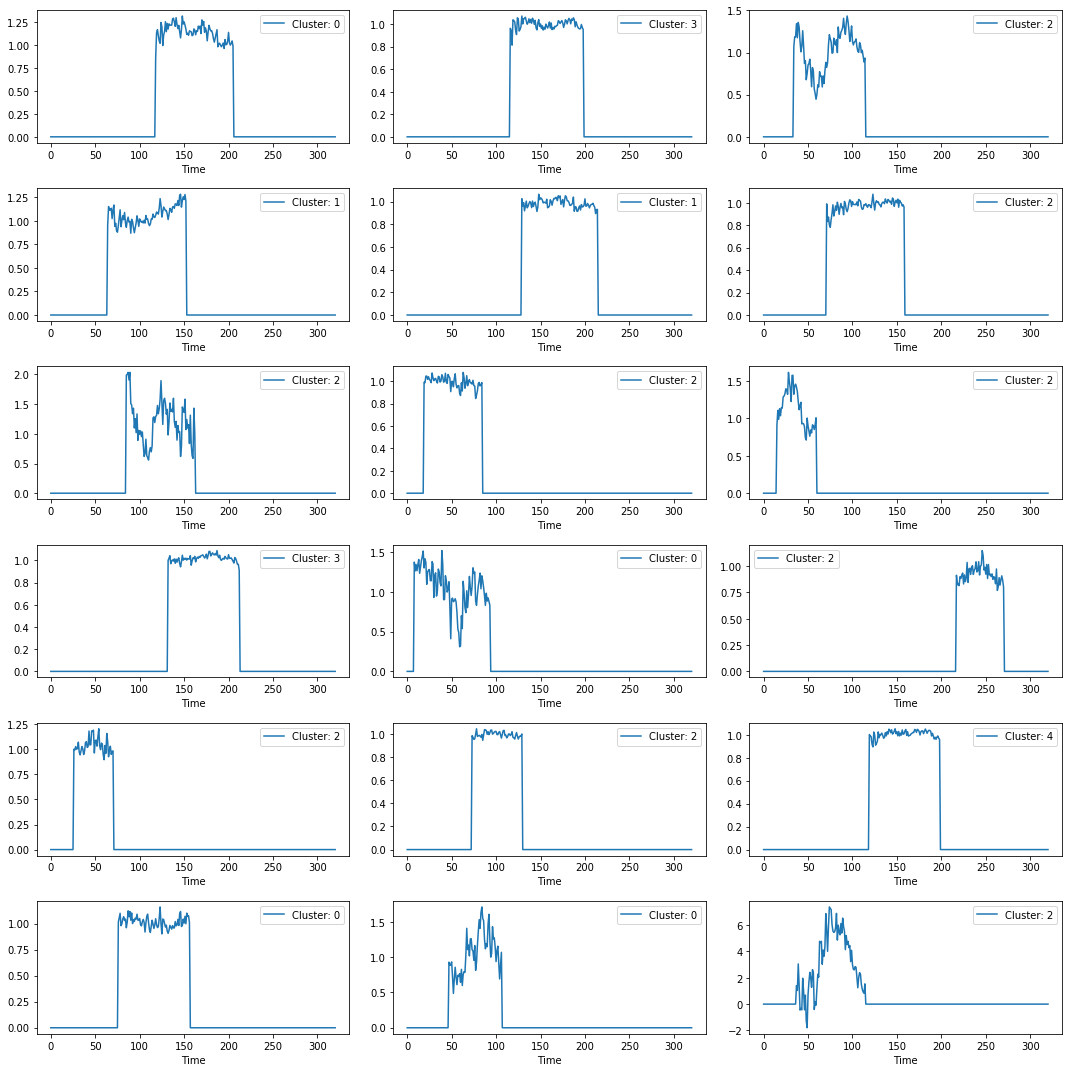

In [16]:
# Apply clustering to a projection of the normalized Laplacian.
clustering = SpectralClustering(n_clusters=5, 
                                random_state=42, 
                                n_init=10, 
                                affinity='precomputed')
labels = clustering.fit_predict(A_hat)

_, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axis in enumerate(axes.ravel()):
    
    axis.plot(M_sub[i], label=f"Cluster: {labels[i]}")
    axis.set_xlabel("Time")
    axis.legend()
    
plt.tight_layout()

# Questions
* How to come up with good candidates for $A$.
    - Side-information?
    - Surrogate model?
* Can have analytical expression for loss (+ terms ensuring properties of A) and use GD?
* Alternative definition of local smoothness?